In [1]:
import json
from sklearn.utils import shuffle
import librosa
import numpy as np
from scipy.signal import resample
import os
import glob
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import torch.nn as nn
from transformers import BertModel, BertConfig
import torch.optim as optim
from torch.nn import CrossEntropyLoss
from torch.nn.utils.rnn import pad_sequence
import metrics

In [3]:
def pad_and_split_audio(y, sr, target_length=8, interval_length=0.05):
    # Pad the audio to 8 seconds
    target_samples = target_length * sr
    if len(y) < target_samples:
        y = np.pad(y, (0, target_samples - len(y)), mode='constant')
    else:
        y = y[:target_samples]

    # Split the audio into 0.05-second intervals
    interval_samples = int(sr * interval_length)
    intervals = [y[i:i + interval_samples] for i in range(0, len(y), interval_samples)]
    
    return intervals

In [4]:
def load_audio_files_and_labels(json_path, audio_dir, sr=8000, target_length=8, interval_length=0.05):
    with open(json_path, 'r') as f:
        annotations = json.load(f)

    audio_sequences = []
    sequence_labels = []

    # Create a dictionary to map the first 47 characters of the file names to the full file names
    audio_file_dict = {}
    for file_name in os.listdir(audio_dir):
        if file_name.endswith('.wav'):
            base_name = file_name[:47]
            audio_file_dict[base_name] = file_name

    for audio_base_name, intervals_labels in annotations.items():
        if audio_base_name in audio_file_dict:
            audio_file_path = os.path.join(audio_dir, audio_file_dict[audio_base_name])
            y, sr = librosa.load(audio_file_path, sr=sr)
            intervals = pad_and_split_audio(y, sr, target_length, interval_length)

            interval_labels = []
            for i, interval in enumerate(intervals):
                interval_start = i * interval_length
                interval_end = interval_start + interval_length
                interval_label = 0  # Default label
                
                for label_start, label_end, label in intervals_labels:
                    if label_start <= interval_start < label_end:
                        interval_label = label
                        break
                
                interval_labels.append(interval_label)
            
            audio_sequences.append(intervals)
            sequence_labels.append(interval_labels)
        else:
            print(f"Audio file for {audio_base_name} not found")

    return audio_sequences, sequence_labels

def load_negative_samples(negative_audio_dir, sr=8000, target_length=8, interval_length=0.05):
    audio_sequences = []
    sequence_labels = []
    
    for file_name in os.listdir(negative_audio_dir):
        if file_name.endswith('.wav'):
            audio_file_path = os.path.join(negative_audio_dir, file_name)
            y, sr = librosa.load(audio_file_path, sr=sr)
            intervals = pad_and_split_audio(y, sr, target_length, interval_length)
            
            interval_labels = [0] * len(intervals)  # All labels are 0 for negative samples
            
            audio_sequences.append(intervals)
            sequence_labels.append(interval_labels)
    
    return audio_sequences, sequence_labels

audio_dir = '/home/saadeldine.eletter/Baby_Cry/prj/our_Dataset_cry/'
json_path = 'combined_annotations_Approach5.json'
audio_sequences, sequence_labels = load_audio_files_and_labels(json_path, audio_dir)
print("Original Data Loaded Successfully!")


# Load negative samples
negative_audio_dir = '/home/saadeldine.eletter/Baby_Cry/prj/araf/'  
negative_audio_sequences, negative_sequence_labels = load_negative_samples(negative_audio_dir)
print("Dcase Data Loaded Successfully!")

# Concatenate positive and negative samples
audio_sequences.extend(negative_audio_sequences)
sequence_labels.extend(negative_sequence_labels)

# Shuffle the data
audio_sequences, sequence_labels = shuffle(audio_sequences, sequence_labels, random_state=42)

print("Data is Concatenated Successfully!")

print("To Make Sure!")

print(len(audio_sequences[0][0]))
print((sequence_labels[10]))

Original Data Loaded Successfully!
Dcase Data Loaded Successfully!
Data is Concatenated Successfully!
To Make Sure!
400
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Features Extracted Successfully!


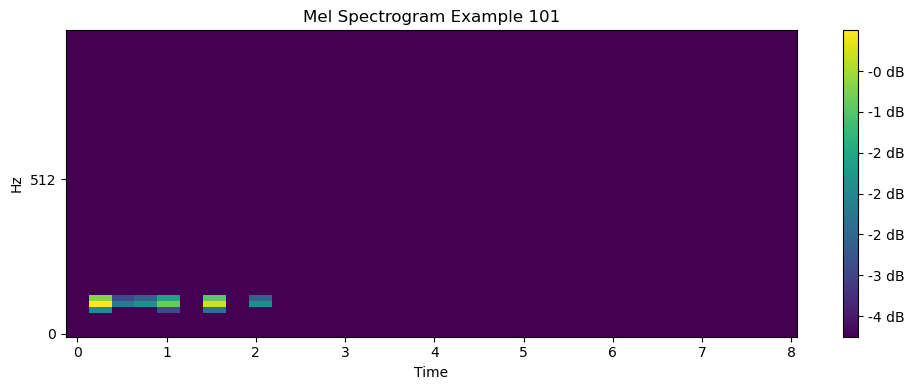

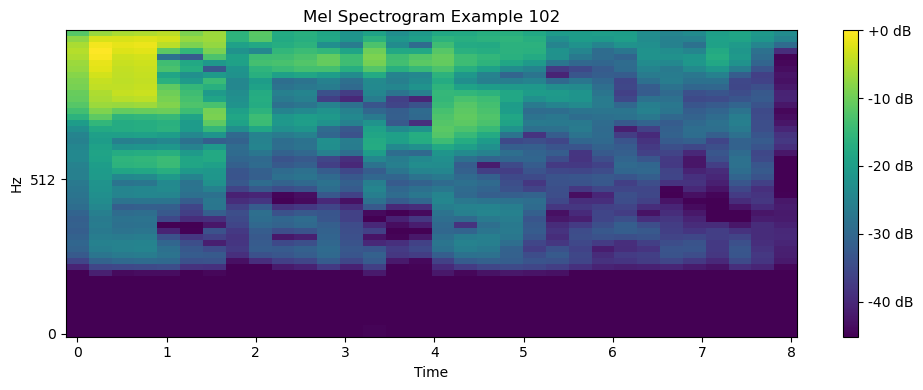

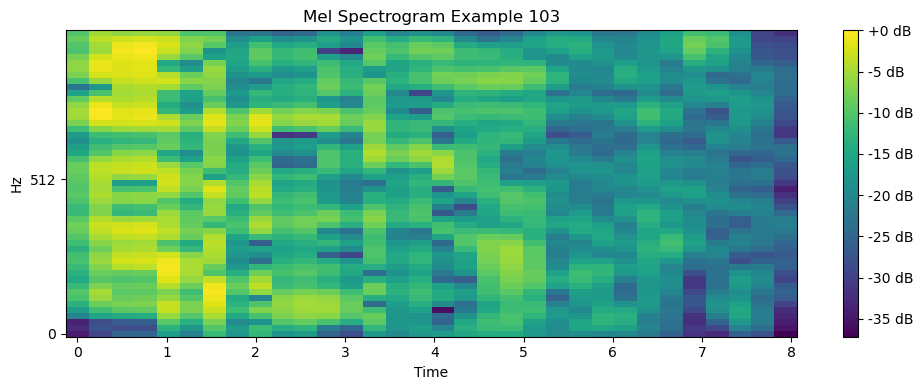

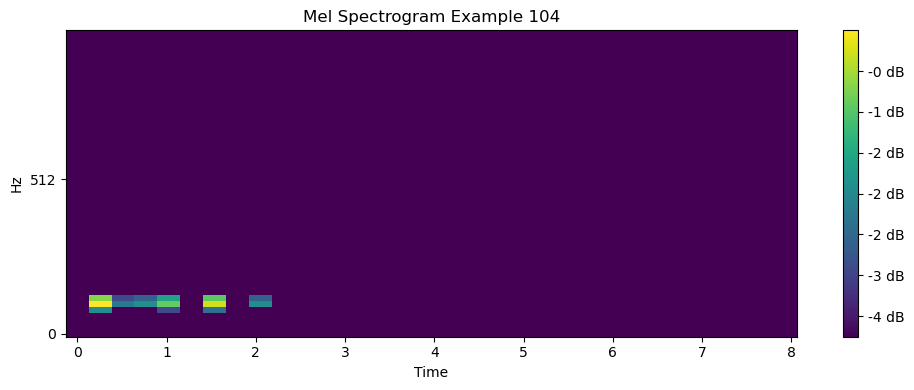

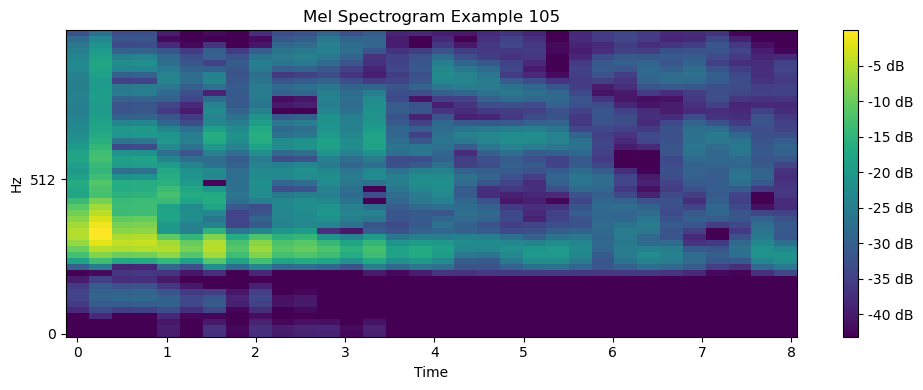

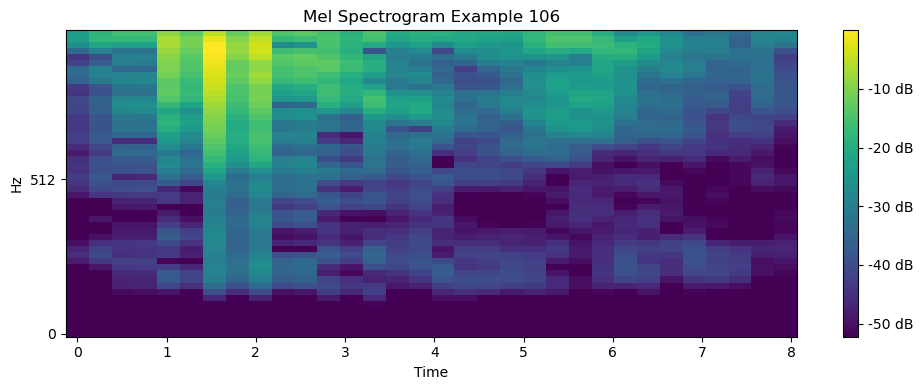

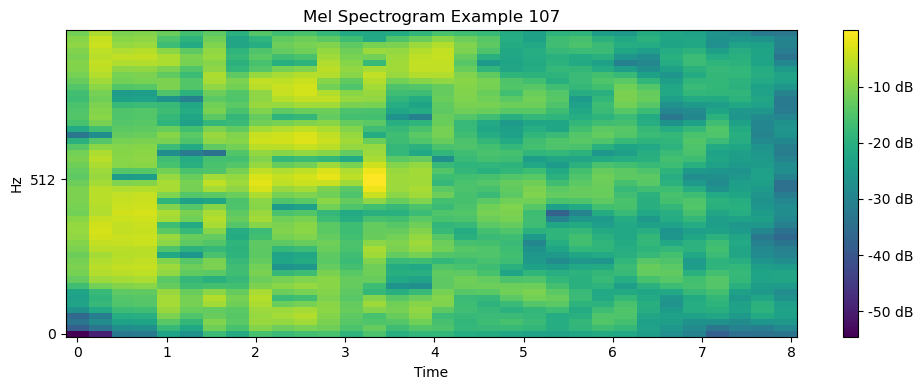

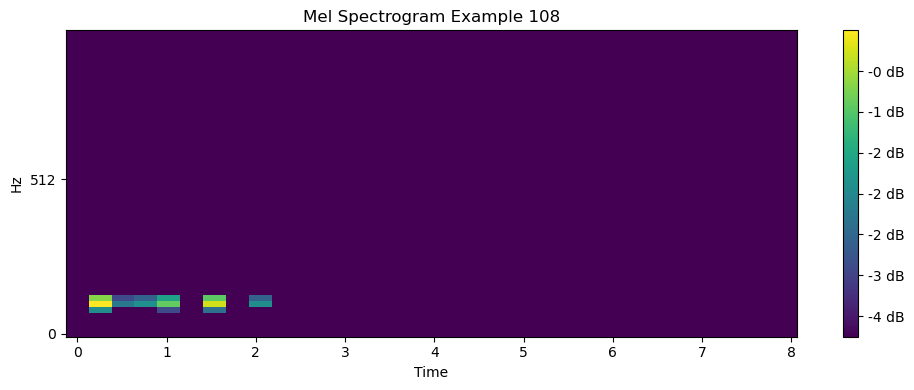

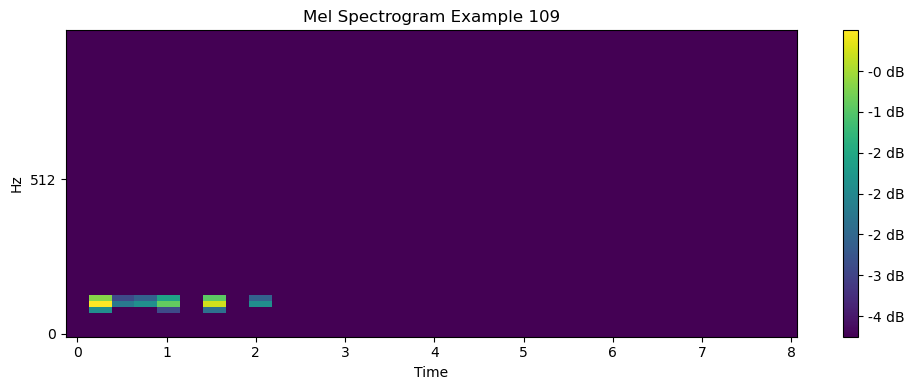

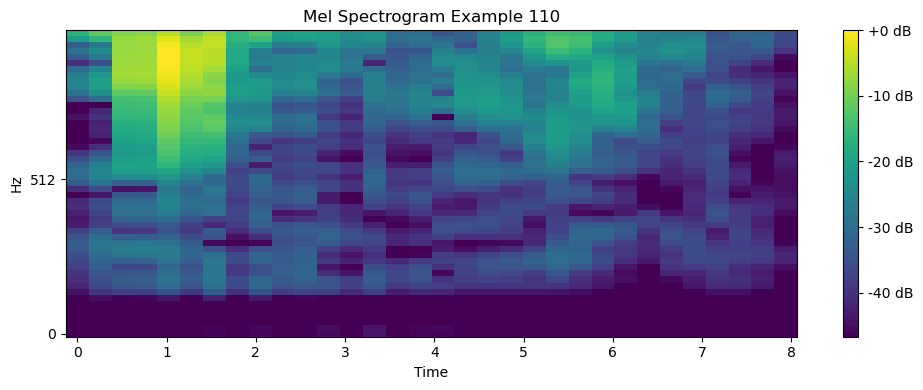

In [5]:
def extract_mel_spectrograms(audio_sequences, sr=8000, n_mels=32, n_fft=64, hop_length=8):
    feature_sequences = []
    for sequence in audio_sequences:
        features = []
        for y in sequence:
            mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length)
            log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
            features.append(log_mel_spectrogram.T)
        feature_sequences.append(features)
    return feature_sequences

feature_sequences = extract_mel_spectrograms(audio_sequences)
print("Features Extracted Successfully!")


def plot_spectrogram(spectrogram, title="Mel Spectrogram"):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(spectrogram, sr=2000, x_axis='time', y_axis='mel', cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Plot the first few spectrograms from the first interval of each sequence
for i in range(100, 110):
    if i < len(feature_sequences):
        if len(feature_sequences[i]) > 0:
            plot_spectrogram(feature_sequences[i][0], title=f"Mel Spectrogram Example {i+1}")
        else:
            print(f"Sequence {i+1} has no intervals.")
    else:
        break

In [9]:
class CrySequenceDataset(Dataset):
    def __init__(self, feature_sequences, sequence_labels, max_len=160):
        self.feature_sequences = feature_sequences
        self.sequence_labels = sequence_labels
        self.max_len = max_len

    def __len__(self):
        return len(self.feature_sequences)

    def __getitem__(self, idx):
        feature_sequence = self.feature_sequences[idx]
        label_sequence = self.sequence_labels[idx]

        # Pad or truncate each feature sequence to max_len
        padded_features = []
        for feature in feature_sequence:
            if feature.shape[0] < self.max_len:
                pad_width = self.max_len - feature.shape[0]
                feature = np.pad(feature, ((0, pad_width), (0, 0)), mode='constant')
            else:
                feature = feature[:self.max_len, :]
            padded_features.append(feature)

        padded_features = np.array(padded_features)
        feature_tensor = torch.tensor(padded_features, dtype=torch.float32)
        label_tensor = torch.tensor(label_sequence, dtype=torch.long)
        return feature_tensor, label_tensor

# Convert labels to integers
mapped_sequence_labels = [list(map(int, labels)) for labels in sequence_labels]

# Instantiate the dataset
dataset = CrySequenceDataset(feature_sequences, mapped_sequence_labels, max_len=160)

# Print dataset details
print(f"Total number of samples: {len(dataset)}")
print(f"Unique labels: {set(label for labels in sequence_labels for label in labels)}")

Total number of samples: 468
Unique labels: {0, 1}


In [10]:

import json
from sklearn.utils import shuffle
import librosa
import numpy as np
import os
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from torchvision import models, transforms
# Split the dataset
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

print(f"Training set size: {len(train_dataset)}")
print(f"Test set size: {len(test_dataset)}")


def collate_fn(batch):
    feature_sequences, label_sequences = zip(*batch)
    padded_feature_sequences = pad_sequence([torch.tensor(f, dtype=torch.float32).clone().detach() for f in feature_sequences], batch_first=True)
    padded_label_sequences = pad_sequence([torch.tensor(l, dtype=torch.long).clone().detach() for l in label_sequences], batch_first=True)
    return padded_feature_sequences, padded_label_sequences


train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)

print(f"Number of batches in training set: {len(train_loader)}")
print(f"Number of batches in test set: {len(test_loader)}")

Training set size: 374
Test set size: 94
Number of batches in training set: 47
Number of batches in test set: 12


In [13]:
class CryMobileNetV2(nn.Module):
    def __init__(self):
        super(CryMobileNetV2, self).__init__()
        self.mobilenetv2 = models.mobilenet_v2(pretrained=True)
        self.mobilenetv2.features[0][0] = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        self.mobilenetv2.classifier[1] = nn.Linear(self.mobilenetv2.last_channel, 1)  # Binary classification

    def forward(self, x):
        batch_size, num_intervals, seq_length, feature_dim = x.size()
        x = x.view(batch_size * num_intervals, 1, seq_length, feature_dim)  # (batch_size*num_intervals, 1, seq_length, feature_dim)
        x = self.mobilenetv2(x)
        x = x.view(batch_size, num_intervals, -1)  # Reshape back to (batch_size, num_intervals, 1)
        return x


print("#######################################################################")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = CryMobileNetV2()
model.to(device)

#######################################################################
Using device: cuda


CryMobileNetV2(
  (mobilenetv2): MobileNetV2(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_

In [28]:
def train_model(model, train_loader, num_epochs=10):
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=0)
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        count = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            count += 1
            optimizer.zero_grad()
            outputs = model(inputs)
            outputs = outputs.view(-1)
            labels = labels.view(-1).float()  # Convert labels to float for BCEWithLogitsLoss
            
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        scheduler.step()
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}, LR: {scheduler.get_last_lr()[0]}')

train_model(model, train_loader)

/tmp/ipykernel_687274/3261915162.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_feature_sequences = pad_sequence([torch.tensor(f, dtype=torch.float32).clone().detach() for f in feature_sequences], batch_first=True)
/tmp/ipykernel_687274/3261915162.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_label_sequences = pad_sequence([torch.tensor(l, dtype=torch.long).clone().detach() for l in label_sequences], batch_first=True)


Epoch 1/10, Loss: 0.24790657454348625, LR: 0.0009755282581475768
Epoch 2/10, Loss: 0.2366037092944409, LR: 0.0009045084971874736
Epoch 3/10, Loss: 0.2308164343554923, LR: 0.0007938926261462366
Epoch 4/10, Loss: 0.2266996182659839, LR: 0.0006545084971874737
Epoch 5/10, Loss: 0.22203260723580706, LR: 0.0005
Epoch 6/10, Loss: 0.23123234859172334, LR: 0.00034549150281252633
Epoch 7/10, Loss: 0.2225673236745469, LR: 0.0002061073738537635
Epoch 8/10, Loss: 0.21251226200702342, LR: 9.549150281252634e-05
Epoch 9/10, Loss: 0.21294960633237311, LR: 2.4471741852423235e-05
Epoch 10/10, Loss: 0.21197182352238514, LR: 0.0


In [15]:
def save_model(model, path):
    torch.save(model.state_dict(), path)
    print(f"Model saved to {path}")

# Specify the path where you want to save the model
model_save_path = 'MobileNETV2.pth'

# Save the trained model
save_model(model, model_save_path)

Model saved to MobileNETV2.pth


/tmp/ipykernel_687274/3261915162.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_feature_sequences = pad_sequence([torch.tensor(f, dtype=torch.float32).clone().detach() for f in feature_sequences], batch_first=True)
/tmp/ipykernel_687274/3261915162.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_label_sequences = pad_sequence([torch.tensor(l, dtype=torch.long).clone().detach() for l in label_sequences], batch_first=True)


Accuracy: 90.30%
              precision    recall  f1-score   support

  non-crying       0.89      0.94      0.91      8063
      crying       0.92      0.86      0.89      6977

    accuracy                           0.90     15040
   macro avg       0.91      0.90      0.90     15040
weighted avg       0.90      0.90      0.90     15040



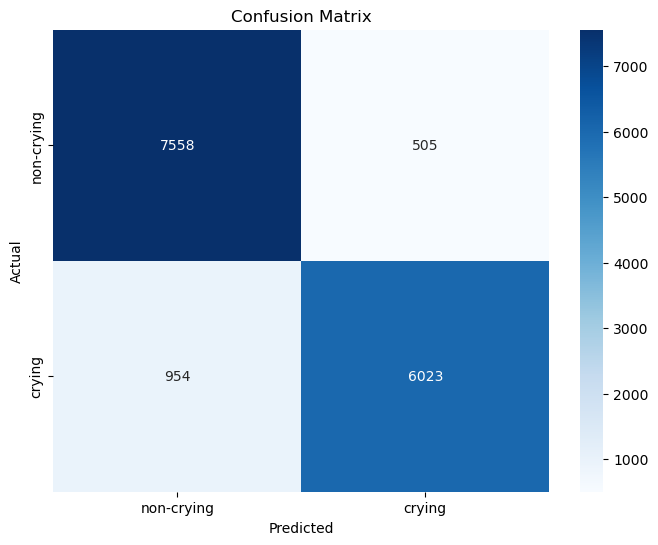

In [29]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import torch

def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            # Move inputs and labels to GPU
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            outputs = outputs.view(-1)
            labels = labels.view(-1).float()  # Convert labels to float for BCEWithLogitsLoss
            
            preds = torch.sigmoid(outputs)  # Apply sigmoid to get probabilities
            preds = (preds > 0.5).float()  # Convert probabilities to binary predictions
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = accuracy_score(all_labels, all_preds)
    print(f'Accuracy: {accuracy * 100:.2f}%')
    print(classification_report(all_labels, all_preds, target_names=['non-crying', 'crying']))
    
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['non-crying', 'crying'], yticklabels=['non-crying', 'crying'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

# Evaluating the model
evaluate_model(model, test_loader)

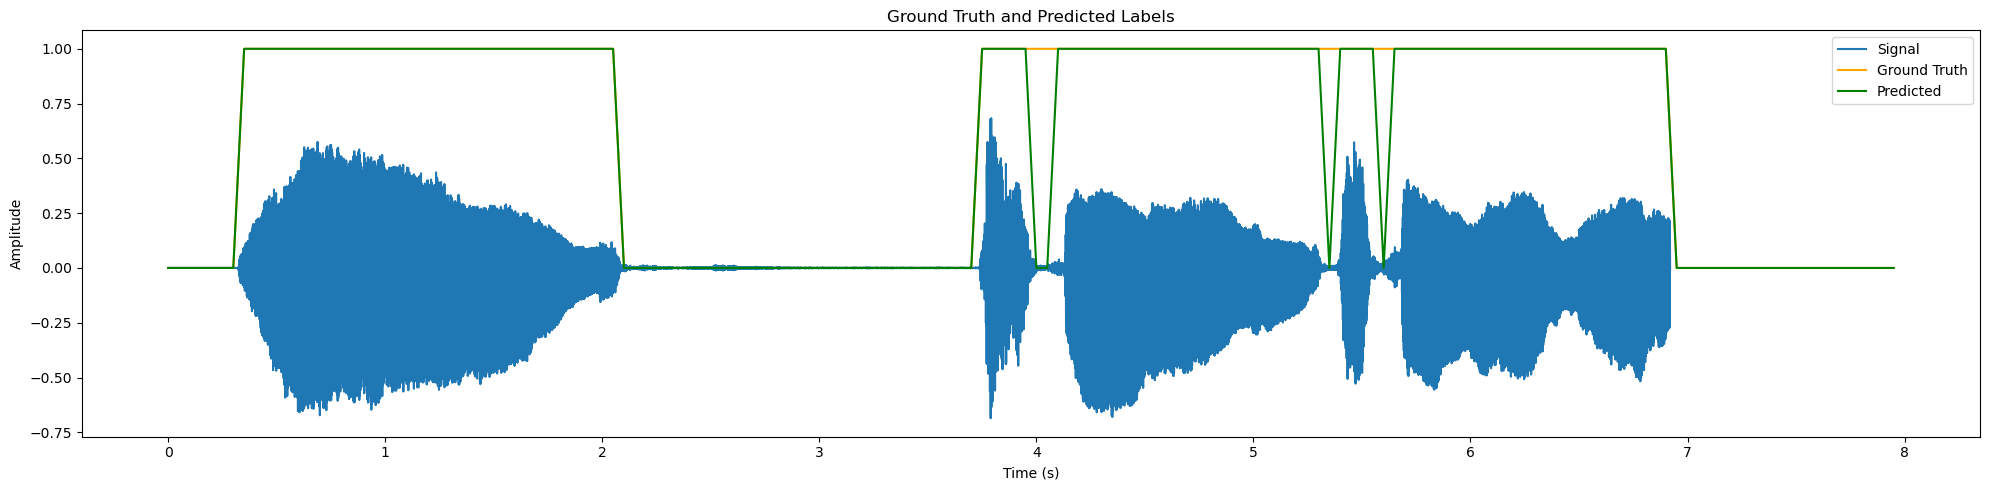

In [33]:
import json
import numpy as np
import torch
import librosa
import matplotlib.pyplot as plt

# Load the JSON file with annotations
json_path = 'combined_annotations_Approach5.json'
with open(json_path, 'r') as f:
    annotations = json.load(f)

# Load and preprocess the specific audio file
audio_file_path = '/home/saadeldine.eletter/Baby_Cry/prj/our_Dataset_cry/e4051e62-d21d-4bb8-a235-fd7e859ad787-1430739655763-1.7-m-04-hu.wav'
y, sr = librosa.load(audio_file_path, sr=8000)
intervals = pad_and_split_audio(y, sr, target_length=8, interval_length=0.05)

# Extract Mel spectrogram features
def extract_mel_spectrogram(y, sr=8000, n_mels=32, n_fft=64, hop_length=8):
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length)
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
    return log_mel_spectrogram.T

feature_sequence = [extract_mel_spectrogram(interval, sr) for interval in intervals]

# Pad or truncate each feature sequence to max_len
max_len = 160
padded_features = []
for feature in feature_sequence:
    if feature.shape[0] < max_len:
        pad_width = max_len - feature.shape[0]
        feature = np.pad(feature, ((0, pad_width), (0, 0)), mode='constant')
    else:
        feature = feature[:max_len, :]
    padded_features.append(feature)

padded_features = np.array(padded_features)
feature_tensor = torch.tensor(padded_features, dtype=torch.float32).unsqueeze(0)  # Add batch dimension

# Run the model on the preprocessed features
model.eval()
with torch.no_grad():
    feature_tensor = feature_tensor.to(device)
    outputs = model(feature_tensor)
    outputs = outputs.view(-1)
    preds = torch.sigmoid(outputs)  # Apply sigmoid to get probabilities
    preds = (preds > 0.5).float()  # Convert probabilities to binary predictions
    predicted_labels = preds.cpu().numpy()

# Extract ground truth labels from JSON annotations
audio_base_name = os.path.basename(audio_file_path)[:47]
interval_length = 0.05
ground_truth_labels = []
if audio_base_name in annotations:
    intervals_labels = annotations[audio_base_name]
    for i in range(len(intervals)):
        interval_start = i * interval_length
        interval_end = interval_start + interval_length
        interval_label = 0  # Default label
        for label_start, label_end, label in intervals_labels:
            if label_start <= interval_start < label_end:
                interval_label = label
                break
        ground_truth_labels.append(interval_label)
else:
    ground_truth_labels = [0] * len(predicted_labels)  # Default to zeros if not found

# Plot the audio signal with ground truth and predicted labels
def plot_audio_with_labels(signal, sr, ground_truth_labels, predicted_labels, interval_length=0.05, title="Ground Truth and Predicted Labels"):
    # Time axis for the signal
    time_axis = np.arange(len(signal)) / sr
    
    # Time axis for the labels
    label_time_axis = np.arange(len(ground_truth_labels)) * interval_length
    
    plt.figure(figsize=(20, 5))
    plt.plot(time_axis, signal, label='Signal')
    plt.plot(label_time_axis, ground_truth_labels, label='Ground Truth', color='orange')
    plt.plot(label_time_axis, predicted_labels, label='Predicted', color='green')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_audio_with_labels(y, sr, ground_truth_labels, predicted_labels, interval_length=0.05)
